Peace, Love, Salad, Rats adn introductory text.


In [1]:
import numpy as np
import pandas as pd
import scipy
import skbio
import biom

import matplotlib.pyplot as plt
import americangut.power_plots as pp

from matplotlib import rcParams
from skbio.stats.power import subsample_power
# import seaborn as sns

In [2]:
from statsmodels.stats.power import FTestAnovaPower, TTestIndPower
ft = FTestAnovaPower()
tt = TTestIndPower()

In [3]:
# Displays images inline
%matplotlib inline

# Sets up plotting parameters so that the default setting is use to Helvetica
# in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True

# # Plots using seaborn
# import seaborn as sns

Let's start with an easy example, where we look at the power comparing normal distributions.
Statistical power for two independent samples is given by
$$ PWR(|\mu_{1} - \mu_{2}|) = P\left (Z < - z_{(1 - \alpha/ 2)} + \frac{|\mu_{1} - \mu_{2}|}{\sqrt{\sigma_{1}^{2}/n_{1} + \sigma_{2}^{2}/n_{2}}} \right )$$

$$ PWR(|\mu_{1} - \mu_{2}|) = norm \left (-z_{(1 - \alpha/2)} + \frac{|\mu_{1} - \mu_{2}|}{\sqrt{\sigma_{1}^{2}/n_{1} + \sigma_{2}^{2}/n_{2}}}, 0, 1 \right )$$

Where $norm$ is the normal distribution.

We can translate this into a python function we can use to predict the statistical power of a set of two distributions based on their functional parameters.


In [4]:
def ttest_2_ind_pwr(n, mu1, mu2, sigma1, sigma2, alpha=0.05):
    """Calculates the stastical power for two independent normal distributions
    
    Parameters
    ----------
    n : array
        A 1 dimensional array giving the counts for power calculation.
    mu1, mu2 : float
        The means for the two distributions being compared.
    sigma1, sigma2 : float
        The standard deviations for the two distributions being compared.
    alpha : float, optional
        The critical value for the comparison.
    
    Returns
    -------
    beta : array
        The statistcal power at each sample count.
    
    """
    # Calculates the effect size for the comparison
    eff = (np.absolute(mu1 - mu2) / 
           np.sqrt(np.square(sigma1) + np.square(sigma2)))

    # Gets the z-distribution test statistic for alpha
    z_alpha = scipy.stats.norm.ppf(1 - alpha / 2)

    # Calculates the z-statistic distribution for beta
    beta = scipy.stats.norm.cdf(-z_alpha + eff * np.sqrt(n))
    
    return beta

We're also going to stop here to define a function that will make for prettier plots later. 

In [5]:
def format_hist_ax(ax, xlim, ylim, xint):
    """Makes a pretty histogram instances for generalized histogram display
    
    Parameters
    ax : matplotlib axes
        The axis containing the plot
    xlim : list
        The limits for the x-axis in the format [lower, upper].
    ylim : list
        The limits for the y-axis in the format [lower, upper].
    xint : float
        The spacing between ticks on the x-axis.
    """
    # Formats the axis limits
    ax.set_xlim(xlim)
    ax.set_xticks(np.arange(xlim[0], xlim[1] + xint, xint))
    ax.set_ylim(ylim)
    
    # Formats the lines around the axis to make them pretty
    ax.set_xticklabels('')
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_xaxis().set_tick_params(direction='out')

Let's start by setting up some parameters for our distributions. We'll focus on comparing the she shape of distributions based on the ratio between their means and their standard deviation.

In [6]:
# Sets the ratio of differences between the means and standard devation
mean_diff_to_std_ratio = 0.75
# Sets the mean for the first distribution
mu1 = 0
# Sets the mean for hte standard devation
sigma = 10
# Sets the difference
mu2 = mu1 + sigma*mean_diff_to_std_ratio

We can plot the two distributions to show the differences in the two distributions

In [7]:
# Identifies the two populations
domain = np.arange(-50, 50, 0.5)
population1 = scipy.stats.norm.pdf(domain, mu1, sigma)
population2 = scipy.stats.norm.pdf(domain, mu2, sigma)

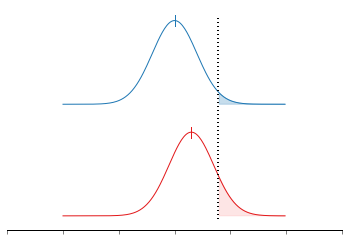

In [8]:
# Determines the 95% confidence value for the first population
pop1_95 = mu1 + scipy.stats.norm.ppf(1 - 0.05/2)*sigma

# Creates a figure for plotting thet wo distributions
# pop_fig = plt.figure()
ax1 = plt.axes()
# Plots the two distributions
ax1.plot(domain, population1/population1.max()*0.75 + 1.125, color='#1f78b4')
ax1.plot(domain, population2/population2.max()*0.75 + 0.125, color='#e31a1c')

# Plots the 95% confidence fill in on the first distribution
ax1.fill_between(x=domain[domain > pop1_95], y1=1.125, 
                 y2=population1[domain > pop1_95]/population1.max()*0.75 + 1.125, 
                 alpha=0.25, color='#1f78b4')
ax1.fill_between(x=domain[domain > pop1_95], y1=0.125,
                 y2=population2[domain > pop1_95]/population2.max()*0.75 + 0.125, 
                 alpha=0.25, color='#fb9a99')

# Massages the axes to make them look the way we want them to
format_hist_ax(ax1, [-75, 75], [0, 2], 25)

# Denotes the means
ax1.plot([mu1, mu1], [1.825, 1.925], color='#1f78b4')
ax1.plot([mu2, mu2], [0.825, 0.925], color='#e31a1c')

# Adds a line
ax1.plot([pop1_95]*2, [0.1, 1.9], 'k:', linewidth=2)

pop_fig = ax1.get_figure()
pop_fig.savefig('/Users/jwdebelius/Desktop/pop_fig.png')

Let's draw random sets of samples that are predictive of the underlying populations.

In [9]:
samples = []

for n_obs in np.array([25, 50, 100, 1000]):
    # Draws the samples
    sample1 = np.random.randn(n_obs)*sigma + mu1
    sample2 = np.random.randn(n_obs)*sigma + mu2
    
    samples.append((sample1, sample2))

In [10]:
# Defines a statistical test for 
ttest_ind = lambda x: scipy.stats.ttest_ind(x[0], x[1])[1]

counts = np.hstack((np.arange(2, 20, 1), np.arange(20, 100, 5)))

In [19]:
for samp in samples:
    print '%1.2e' % ttest_ind(samp)

3.19e-06
1.32e-04
2.90e-09
4.04e-63


We'll plot the  distributions as histograms, to check that they look the way we expect.

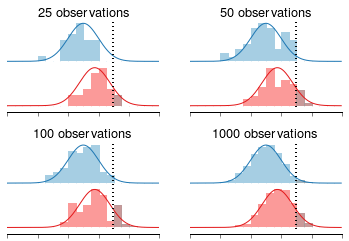

In [12]:
dist_fig = plt.figure()

ids1 = np.array([1, 2, 5, 6])
ids2 = np.array([3, 4, 7, 8])
n_observations = np.array([25, 50, 100, 1000])
for idx, (sample1, sample2) in enumerate(samples):
    
    # Bins the data into a histogram
    bins = np.arange(-50, 55, 5)
    hist1, bins = np.histogram(sample1, bins)
    hist2, bins = np.histogram(sample2, bins)
    bins = bins[:-1]
    # Adds the axis for the data
    
#     ax2 = dist_fig.add_subplot(4, 2, id1)
    
    # Plots the first histogram and distribution
    ax1 = dist_fig.add_subplot(2, 2, idx+1)
    ax1.bar(bins, hist1/float(hist1.max())*0.75, width=5, 
            bottom=1, color='#a6cee3', edgecolor='#a6cee3')
    ax1.bar(bins[bins > pop1_95], hist1[bins > pop1_95]/float(hist1.max())*0.75, width=5,
            bottom=1, color='#999999', edgecolor='#999999', alpha=0.5)
    ax1.bar(bins, hist1*0, width=5, bottom=1, color='w', edgecolor='w')
    ax1.plot(domain, population1/population1.max()*0.75 + 1, color='#1f78b4')
    
    # Plots the second distribution
    ax1.bar(bins, hist2/float(hist2.max())*0.75, width=5,
             bottom=0.125, color='#fb9a99', edgecolor='#fb9a99')
    ax1.bar(bins[bins > pop1_95], hist2[bins > pop1_95]/float(hist2.max())*0.75, width=5,
            bottom=0.125, color='#999999', edgecolor='#999999', alpha=0.5)
    ax1.bar(bins, hist2*0, width=5, bottom=0.125, color='w', edgecolor='w')
    ax1.plot(domain, population2/population2.max()*0.75 + 0.125, color='#e31a1c')
    
    # Plots the 95% confidence line
    ax1.plot([pop1_95]*2, [0.1, 1.8], 'k:', linewidth=2)
    
    # Cleans up the axes
    format_hist_ax(ax1, [-50, 50], [0, 2], 20)
    
    # Addsa a title
    t = ax1.set_title('%i observations' % n_observations[idx], size=13)
    t.set_position((t.get_position()[0], t.get_position()[1]*0.9))

Next, we're going to predict the statistical power curve for our samples in multiple ways. We'll use the traditional method. We'll also predict 

In [13]:
power_results = []
for idx, (sample1, sample2) in enumerate(samples):
    # Determines distribution statitics
    x1 = sample1.mean(); s1 = sample1.std()
    x2 = sample2.mean(); s2 = sample2.std()
    
    # Sets up arguments based on the sample size
    max_counts = np.array([len(sample1) - 1, 65]).min()
    
    # Calculates the t-test p value
    t_test_p = ttest_ind([sample1, sample2])
    # Calculates the traditional power
    power_trad = ttest_2_ind_pwr(counts, x1, x2, s1, s2, alpha=0.05)
    # Calculates the emperical power
    pwr_, cnts = subsample_power(ttest_ind, [sample1, sample2], 
                                 min_counts=5, max_counts=max_counts, counts_interval=5,
                                 num_runs=3)
    # Gets the effect
    eff_mean, eff_bound = pp.collate_effect_size([cnts], [pwr_], alpha=0.05)
    # Extraploates the power
    elc_f_pwr = np.array([ft.solve_power(eff_mean[0], nobs=c, alpha=0.05, power=None) for c in counts])
    elc_t_pwr = np.array([tt.solve_power(eff_mean[0], nobs1=c, alpha=0.05, power=None) for c in counts])
    
    # Adds the data to the holding object
    power_results.append((t_test_p, power_trad, elc_f_pwr, elc_t_pwr, (cnts, pwr_)))

Now, we can plot a comparison of the power curves.

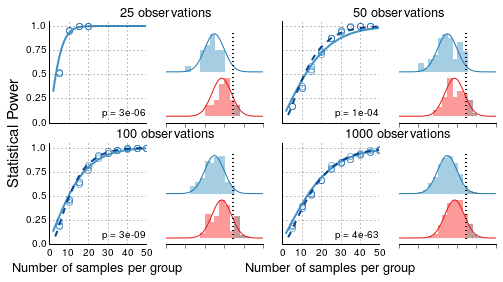

In [14]:
comb_fig = plt.figure()
for idx, (sample1, sample2) in enumerate(samples):
    # Gets the power results
    (t_p, trad, eluc_f, eluc_t, (cnts, pwr_)) = power_results[idx]
    
    # Sets axis counters
    id1 = idx*2 + 1
    id2 = idx*2 + 2
            
    # Sets up the axes for plotting
    ax1 = comb_fig.add_subplot(2, 4, id1)
    ax2 = comb_fig.add_subplot(2, 4, id2)

    # Bins the sample data into histograms
    bins = np.arange(-50, 55, 5)
    hist1, bins = np.histogram(sample1, bins)
    hist2, bins = np.histogram(sample2, bins)
    bins = bins[:-1]
    
     # Plots the first histogram and distribution
    ax2.bar(bins, hist1/float(hist1.max())*0.75, width=5, 
            bottom=1, color='#a6cee3', edgecolor='#a6cee3')
    ax2.bar(bins[bins > pop1_95], hist1[bins > pop1_95]/float(hist1.max())*0.75, width=5,
            bottom=1, color='#999999', edgecolor='#999999', alpha=0.5)
    ax2.bar(bins, hist1*0, width=5, bottom=1, color='w', edgecolor='w')
    ax2.plot(domain, population1/population1.max()*0.75 + 1, color='#1f78b4')
    
    # Plots the second distribution
    ax2.bar(bins, hist2/float(hist2.max())*0.75, width=5,
             bottom=0.125, color='#fb9a99', edgecolor='#fb9a99')
    ax2.bar(bins[bins > pop1_95], hist2[bins > pop1_95]/float(hist2.max())*0.75, width=5,
            bottom=0.125, color='#999999', edgecolor='#999999', alpha=0.5)
    ax2.bar(bins, hist2*0, width=5, bottom=0.125, color='w', edgecolor='w')
    ax2.plot(domain, population2/population2.max()*0.75 + 0.125, color='#e31a1c')
    
    # Plots the 95% confidence line
    ax2.plot([pop1_95]*2, [0.1, 1.8], 'k:', linewidth=2)

    # Plots the power curves on the left
    ax1.plot(np.array([cnts]*3), pwr_, 'o', mfc='none', mec='#2171b5', linewidth=1)
    ax1.plot(counts, trad, '-', color="#4292c6", linewidth=2)
    ax1.plot(counts, eluc_f, 'b--', color="#084594", linewidth=2)
    
    # Formats the axes
    ax1.set_xlim([0, 50])
    ax1.set_xticks(np.arange(0, 55, 10))
    if idx < 2:
        ax1.set_xticklabels('')
    else:
        ax1.set_xticklabels(map(int, ax1.get_xticks()), size=10)
        xl1 = ax1.set_xlabel('Number of samples per group', size=13)
    ax1.set_ylim([0, 1.05])
    ax1.set_yticks(np.arange(0, 1.1, 0.25))
    if idx in {1, 3}:
        ax1.set_yticklabels('')
    else:
        ax1.set_yticklabels(ax1.get_yticks(), size=10)
    if idx == 2:
        yl1 = ax1.set_ylabel('Statistical Power', size=15, ha='center')
        yl1.set_position((0, 1.1))
    ax1.grid()
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    for tic in ax1.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax1.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
 
    
    format_hist_ax(ax2, [-50, 50], [0, 2], 20)
    
    t = ax1.set_title('%i observations' % len(sample1), size=13, ha='center')
    t.set_position((1.2, 1))
    
    t2 = ax1.text(49, 0.075, 'p = %1.e' % t_p, size=10, ha='right')
    
comb_fig.set_size_inches((8, 4))
comb_fig.savefig('/Users/jwdebelius/Desktop/comb_fig.png')

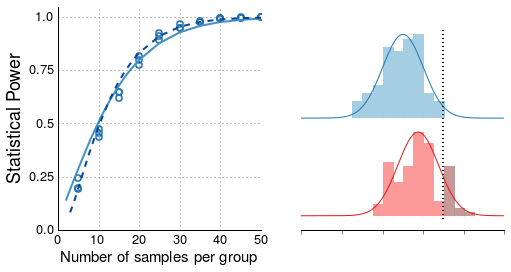

In [35]:
 # Gets the power results
sample1, sample2 = samples[2]
(t_p, trad, eluc_f, eluc_t, (cnts, pwr_)) = power_results[2]
# Sets axis counters
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# Bins the sample data into histograms
bins = np.arange(-50, 55, 5)
hist1, bins = np.histogram(sample1, bins)
hist2, bins = np.histogram(sample2, bins)
bins = bins[:-1]
    
# Plots the first histogram and distribution
ax2.bar(bins, hist1/float(hist1.max())*0.75, width=5, 
        bottom=1, color='#a6cee3', edgecolor='#a6cee3')
ax2.bar(bins[bins > pop1_95], hist1[bins > pop1_95]/float(hist1.max())*0.75, width=5,
        bottom=1, color='#999999', edgecolor='#999999', alpha=0.5)
ax2.bar(bins, hist1*0, width=5, bottom=1, color='w', edgecolor='w')
ax2.plot(domain, population1/population1.max()*0.75 + 1, color='#1f78b4')

 # Plots the second distribution
ax2.bar(bins, hist2/float(hist2.max())*0.75, width=5,
         bottom=0.125, color='#fb9a99', edgecolor='#fb9a99')
ax2.bar(bins[bins > pop1_95], hist2[bins > pop1_95]/float(hist2.max())*0.75, width=5,
        bottom=0.125, color='#999999', edgecolor='#999999', alpha=0.5)
ax2.bar(bins, hist2*0, width=5, bottom=0.125, color='w', edgecolor='w')
ax2.plot(domain, population2/population2.max()*0.75 + 0.125, color='#e31a1c')

# Plots the 95% confidence line
ax2.plot([pop1_95]*2, [0.1, 1.8], 'k:', linewidth=2)


 # Plots the power curves on the left
ax1.plot(np.array([cnts]*3), pwr_, 'o', mfc='none', mec='#2171b5', linewidth=2, mew=1.5)
ax1.plot(counts, trad, '-', color="#4292c6", linewidth=2)
ax1.plot(counts, eluc_f, 'b--', color="#084594", linewidth=2)

# Formats the axes
ax1.set_xlim([0, 50])
ax1.set_xticks(np.arange(0, 55, 10))
ax1.set_xticklabels(map(int, ax1.get_xticks()), size=13)
xl1 = ax1.set_xlabel('Number of samples per group', size=15)
ax1.set_ylim([0, 1.05])
ax1.set_yticks(np.arange(0, 1.1, 0.25))
ax1.set_yticklabels(ax1.get_yticks(), size=13)
yl1 = ax1.set_ylabel('Statistical Power', size=18, ha='center')
ax1.grid()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
for tic in ax1.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
for tic in ax1.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

format_hist_ax(ax2, [-50, 50], [0, 2], 20)
    
t.set_position((1.2, 1))

fig.set_size_inches(8, 4)
fig.savefig('/Users/jwdebelius/Desktop/power_fig.png', dpi=300)

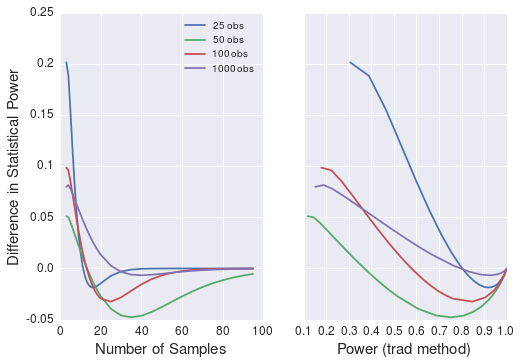

In [15]:
import seaborn as sns

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
for idx, (t_p, trad, eluc_f, eluc_t, (cnts, pwr_)) in enumerate(power_results):
    ax1.plot(counts, (trad - eluc_f))
    ax2.plot(trad, (trad - eluc_f))
#     ax.plot(counts, (trad - eluc_t)/trad, '--')
ax1.set_xticklabels(map(int, ax1.get_xticks()), size=12)
ax2.set_xticklabels(ax2.get_xticks(), size=12)
ax1.set_yticklabels(ax1.get_yticks(), size=12)
ax2.set_yticklabels('')
ax1.set_xlabel('Number of Samples', size=15)
ax1.set_ylabel('Difference in Statistical Power', size=15)
ax2.set_xlabel('Power (trad method)', size=15)

ax1.legend(labels=['25 obs', '50 obs', '100 obs', '1000 obs'])

In [34]:
for idx, (t_p, trad, eluc_f, eluc_t, (cnts, pwr_)) in enumerate(power_results):
    there = np.isnan(np.vstack((trad, eluc_f)).transpose()).any(1) == False
    print scipy.stats.pearsonr(trad[there], eluc_f[there])

(0.9960086846700682, 4.2092520098778095e-34)
(0.99818282478738674, 2.1577235723859609e-39)
(0.99714602059173163, 2.3429521607534169e-36)
(0.99975300600724715, 8.0284338649005273e-53)
